# Setup
<ul>
    <li> Choose the world environment, and define a sampler function that generates random initializations of this environment.
    <li> Set up REINFORCE and define model arguments.
    <li> Train REINFORCE on an example instance of the world you set up in step one.
</ul>

### Set up the world environment

In [1]:
from sim import Continuous2D
from sim import MazeArgs

In [2]:
import numpy as np

def sample_task():
    args = MazeArgs()
    args.goal = list(np.random.uniform(low = -2, high = 2, size=(2,)))
    args.agent = [0., 0.]
    maze = Continuous2D(args)
    return maze

In [3]:
# sample way to make an environment
args = MazeArgs()
args.goal = [1.42, -1.976]
args.agent = [0., 0.]
maze = Continuous2D(args)

### Set up REINFORCE

In [4]:
from reinforce import REINFORCE
import utils_training

from utils import ActorContinuous

In [5]:
class ModelArgs():   
    def __init__(self, world):
        # type of model related arguments
        self.seed = 1
        self.state_input_size = world.state_size
        self.action_space_size = world.num_actions
        self.lr = 3e-4
        self.ppo = True
        self.ppo_base_epsilon = 0.2
        self.ppo_dec_epsilon = 0.0
        self.use_critic = True
        self.use_entropy = False

        # training related arguments
        self.gradient_clipping = True
        self.random_perm = True
        self.num_batches = 300
        self.num_mini_batches = 1
        self.batch_size = 5
        self.horizon = 100
        self.weight_func = lambda batch_num: (1 - batch_num/self.num_batches)**2
        
        # policy
        self.policy = ActorContinuous
        self.log_goal_locs = False
        self.hidden_size = 100

### Train on a single world

In [6]:
QUICK_RUN = True
if not QUICK_RUN:
    model_args = ModelArgs(Continuous2D)
    model_args.log_goal_locs = True
    model_args.num_batches = 500
    model_args.batch_size = 5
    model_args.num_mini_batches = 2
    model = REINFORCE(model_args)
    rewards, losses = model.train(maze.generate_fresh())

    # plot rewards
    utils_training.plot_rewards(rewards, folder=None)
    utils_training.plot_goal_loc()

### View the model's trajectory on the example world

In [7]:
import utils
import matplotlib.pyplot as plt
import torch

def plot_path(model, env):
    states, A, R = utils.generate_episode(model.policy, env.generate_fresh(), 100)
    locs = np.array([list(s) for s in states])
    plt.plot(locs[::,0], locs[::,1])

if not QUICK_RUN:
    plot_path(model, maze)

# Compare different initializations from fast adaptation algorithms
<ul>
    <li> Batch REPTILE
    <li> Batch pretraining on samples of environment
    <li> Random initialization
</ul>

In [8]:
# with each method, we add the method's resulting parameters to PARAMS_LIST
PARAMS_LIST = []

### Batch REPTILE 

In [9]:
from utils_training import update_init_params
from tqdm.notebook import tqdm
import copy
from collections import OrderedDict

NUM_META_ITER = 20
NUM_TASKS = 5
K = 4
ALPHA = 0.1

# random initialization
model_args = ModelArgs(Continuous2D)
model_args.num_batches = K
model_args.batch_size = 1
model = REINFORCE(model_args)

for i in tqdm(range(NUM_META_ITER)):
    tasks = [sample_task() for _ in range(NUM_TASKS)]
    
    init_params = copy.deepcopy(OrderedDict(model.policy.named_parameters()))
    temp_params = copy.deepcopy(OrderedDict(model.policy.named_parameters()))

    for t in tasks:
        model.policy.load_state_dict(init_params)
        model.init_optimizers()

        model.train(t)
        target_policy = OrderedDict(model.policy.named_parameters())

        temp_params = update_init_params(target_policy, temp_params, ALPHA/K)
    
    model.policy.load_state_dict(temp_params)

    
result = {
        "pi": model.state_dict(),
        "label": "REPTILE"
    }
PARAMS_LIST.append(result)

-181.10739358563166
-303.66489998481916
-114.03076737277368
-138.4024724046013
-205.78663558317027
-110.27092499069619
-119.59355571182384
-208.08340162704724
-149.74665292613548
-206.53335378388084
-286.9100567055729
-251.8619837964021
-245.91967453725974
-215.6024127933387
-99.10854833066384
-217.4086562919478
-210.21332261680126
-185.48392851404535
-74.43138446516673
-113.24964652827752
-244.51113369874463
-113.53303600741586
-242.72973476228145
-176.86056814082613
-205.65063606963867
-241.34812745820574
-184.25864457875272
-119.86942571648738
-191.45090987298866
-101.37188393818425
-208.37790562891774
-52.15408563649475
-227.743640640479
-244.52087712636376
-181.8129828446745
-85.19211670510997
-192.6042170992372
-199.78019433226024
-234.1170892497365
-278.40264675835556
-147.14519136763542
-203.66682356758892
-167.9843530309634
-229.30152126917207
-169.64880799142477
-287.32650500340196
-224.52381009107336
-75.85027021760038
-103.86231463409482
-43.74488785959807
-246.576991518683

### Set up pretraining

In [ ]:
model_args = ModelArgs(Continuous2D)
model_args.num_batches = 100
model_args.batch_size = 5
model = REINFORCE(model_args)

# we pass the model no enviornment, but just the sampler.
rewards, losses = model.train(None, sample_task)

result = {
        "pi": model.state_dict(),
        "label": "PRETRAIN"
    }
PARAMS_LIST.append(result)

-208.6235180242367
-187.7632247963574
-164.1875246971656


### Random model initialization

In [11]:
model_args = ModelArgs(Continuous2D)
model_args.num_batches = 20
model_args.batch_size = 5
model = REINFORCE(model_args)

result = {
        "pi": model.state_dict(),
        "label": "RANDOM"
    }
PARAMS_LIST.append(result)

### Compare the adaptation speed of initial parameters

In [12]:
import utils_training

In [13]:
NUM_GRAD_UPDATES = 4
NUM_TEST_TASKS = 5

model_args.num_batches = NUM_GRAD_UPDATES
model_args.batch_size = 1
model_args.num_mini_batches = 1
utils_training.compare_parameter_initializations(PARAMS_LIST, model_args, NUM_TEST_TASKS, sample_task)

-178.0737927659808
-114.57250060254422
-120.96704656226873
-41.29320376163468
-194.38638856258416
-181.90019997349592
-119.36856663870036
-118.40786980568069
-39.28414144823421
-189.46644077375618
-177.89177054850825
-112.96913181401439
-120.65542462080231
-41.24514679649434
-195.46725424966556


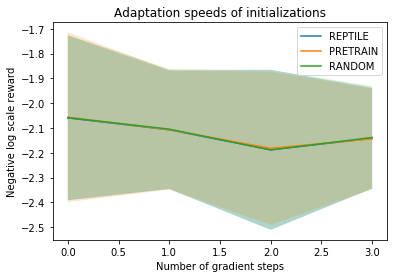

In [14]:
utils_training.plot_adaptation(PARAMS_LIST)